In [51]:
import warnings
warnings.filterwarnings('ignore')

from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun, ShellTool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langgraph.graph import add_messages
from langchain_core.messages import AnyMessage, BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from typing_extensions import TypedDict, Annotated, Sequence, List, Literal, Optional, Dict
import operator
from pprint import pprint
import json
import uuid

# --- 1. Utils (Model, Tools) ---

In [52]:
def _get_model(model_name: str = "openai"):
    """
    Returns an LLM instance based on the specified model name.
    """
    if model_name == "openai":
        # Using gpt-4o-mini for cost-effectiveness and good performance.
        model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
    # elif model_name == "anthropic":
    #     model = ChatAnthropic(temperature=0, model_name="claude-3-5-sonnet-20240620")
    else:
        raise ValueError(f"Unsupported model type: {model_name}")
    return model

# Define the tools to be used.
# Added clearer descriptions for ShellTool inputs and outputs.
tools = [
    DuckDuckGoSearchRun(
        name="duckduckgo_search",
        description="Performs internet searches. Use this to find current information or general knowledge."
    ),
    ShellTool(
        name="shell_tool",
        description="Executes Linux shell commands. Use this for system information, file manipulation, and running network utilities (e.g., ping, nmap). Commands must be provided as a list of strings."
    )
]
# ToolNode will handle the execution of tools and generate ToolMessage.
tool_node = ToolNode(tools)

# --- 2. State Definition ---

In [53]:
class RecoderOptions(TypedDict):
    report: str
    generate_final_report: bool
    file_names: List[str]

class PentestState(TypedDict):
    messages: Annotated[Sequence[AnyMessage], operator.add]
    current_step: Literal['supervisor', 'pentester', 'evaluator', 'recorder', '__end__']
    pentest_tasks: List[str]
    current_task: Optional[str] # The single task currently being executed by the pentester
    evaluation: Optional[str] # The evaluation result from the Evaluator
    model_status: Optional[str] # General status message from the model
    findings: Dict[str, List[str]] # Discovered vulnerabilities (critical, high, medium, low)
    tool_name: Optional[str] # Name of the tool to use (e.g., 'shell_tool', 'duckduckgo_search')
    tool_command: Optional[List[str]] # Command arguments for tool execution (for shell_tool)
    tool_input_message: Optional[AIMessage] # The AIMessage from pentester with tool_calls
    tool_results: Optional[str] # Results from tool execution
    recorder_options: Optional[RecoderOptions]
    pentester_thought: Optional[str] # Pentester's internal thought process
    supervisor_thought: Optional[str] # Supervisor's internal thought process
    evaluator_thought: Optional[str] # Evaluator's internal thought process
    retry_count: int # Count for retries to prevent infinite loops

class GraphConfig(TypedDict):
    model_name: Literal["anthropic", "openai"]

# --- 3. System Prompts ---

In [54]:
PENTESTER_SYSTEM_PROMPT = """
You are a skilled Penetration Testing Expert AI. Your goal is to perform a thorough penetration test
on the provided targets, identify vulnerabilities, and generate relevant reports.
Available tools: {tool_names}.

You must respond in the following structured JSON format.
Based on the user's instructions and previous conversation history, determine the next steps,
propose tasks to perform, the tool to use, and specific commands if necessary.
If a tool needs to be used, set `tool_use` to `true` and specify `tool_name` and `tool_command` accurately.

<example>
User: Perform a fast port scan on 10.10.11.18 and identify open TCP ports.
{{
  "thought": "I need to perform a fast port scan on target 10.10.11.18 to identify open TCP ports. I will use the 'nmap -F' command via the shell_tool.",
  "phase": "Scanning",
  "tasks": ["Perform a fast port scan on 10.10.11.18"],
  "tool_use": true,
  "tool_name": "shell_tool",
  "tool_command": ["nmap", "-F", "10.10.11.18"],
  "summary": "Preparing for fast port scan using Nmap."
}}
</example>
<example>
User: Based on the previous nmap scan results, scan for vulnerabilities on the open SSH port (22).
{{
  "thought": "The previous nmap scan identified port 22 as open. Now, I need to perform a vulnerability scan on this SSH service to find potential weaknesses and report them. I will use Nmap's SSH script modules.",
  "phase": "Vulnerability Analysis",
  "tasks": ["Scan for vulnerabilities on open SSH port (22)"],
  "tool_use": true,
  "tool_name": "shell_tool",
  "tool_command": ["nmap", "-p22", "--script", "ssh-enum-algos,ssh-hostkey,ssh-auth-methods", "10.10.11.18"],
  "summary": "Preparing for SSH service vulnerability analysis."
}}
</example>

"""

EVALUATOR_SYSTEM_PROMPT = """
You are an AI responsible for evaluating the validity and completeness of penetration test results.
You will evaluate the response from the pentester agent and determine if the given task is completed,
or if additional work is required.

Your response must be in the following structured JSON format.
If 'done' is true, it means all tasks are completed, and the program will terminate.
If 'fail' is true, it means further progress is impossible, and the program will terminate.
'findings' should report discovered vulnerabilities by severity.

<example>
Input: Pentester result: Ports 22 and 80 are open.
{{
  "message": "Excellent! The pentester successfully completed the port scan and identified open ports. Please proceed with the next steps.",
  "evaluation": "Port scan completed, proceeding to next phase.",
  "done": false,
  "fail": false,
  "findings": {{}}
}}
</example>
<example>
Input: Pentester result: SSH vulnerability scan found weak encryption algorithms.
{{
  "message": "Weak encryption algorithms were found on the SSH service. This is a critical finding. Include it in the report and continue with further vulnerability analysis.",
  "evaluation": "SSH vulnerability found, further analysis needed.",
  "done": false,
  "fail": false,
  "findings": {{
    "high": ["Weak encryption algorithms found on SSH service (CVE-YYYY-XXXX)"]
  }}
}}
</example>
<example>
Input: Pentester result: Tool execution failed: nmap: command not found
{{
  "message": "The previous command execution failed. It seems 'nmap' was not found. The pentester needs to address this. Retrying is not advised without fixing the environment.",
  "evaluation": "Command execution failed. Requires environment fix or different approach.",
  "done": false,
  "fail": true,
  "findings": {{}}
}}
</example>
"""

SUPERVISOR_SYSTEM_PROMPT = """
You are the supervisor of the penetration testing AI team. You assign tasks to the pentester agent
and determine the next steps based on feedback from the evaluator agent.
Your ultimate goal is to complete the given penetration testing objective and terminate the program
as soon as all tasks are finished.

Your response must be in the following structured JSON format.
If 'done' is true, it means all tasks are completed, and the program will terminate.
'next_agent' must be the name of the agent to whom control will be passed next.

<example>
Input: New pentest request: Website vulnerability assessment.
{{
  "supervisor_thought": "Received a new pentest request. Assigning initial information gathering and port scanning tasks for website vulnerability assessment to the pentester.",
  "tasks": ["Gather initial information for website vulnerability assessment", "Perform port scan on the target website"],
  "next_agent": "pentester",
  "done": false
}}
</example>
<example>
Input: Evaluator: All tasks are completed and a final report needs to be generated.
{{
  "supervisor_thought": "The evaluator reported that all pentesting tasks are completed. Now, I will pass control to the recorder agent to generate the final report.",
  "tasks": [],
  "next_agent": "recorder",
  "done": false
}}
</example>
<example>
Input: Evaluator: Cannot proceed further.
{{
  "supervisor_thought": "The evaluator reported that further progress is impossible. Terminating the pentest.",
  "tasks": [],
  "next_agent": "__end__",
  "done": true
}}
</example>
"""

RECORDER_SUMMARY_PROMPT = """
You are an expert in recording and summarizing information from a chat between a human and an LLM,
where the LLM is utilizing the command line to execute tasks.
Given the history of the last command run, including output logs and previous command prompts:
<history>
{history}
</history>
Generate a summary of this step in LaTeX format.

The summary should be a single LaTeX section and returned in the following JSON format, including the file name.
The file name must include the `.tex` extension.

<example>
{{
  "report": "\\section*{{Port Scan Results Summary}}\\n\\n\\begin{{itemize}}\\n  \\item Target IP: 10.10.11.18\\n  \\item Open Ports: 22(SSH), 80(HTTP)\\n\\end{{itemize}}",
  "file_name": "port_scan_summary.tex"
}}
</example>
"""

RECORDER_FINAL_PROMPT = """
You are an expert in summarizing and reporting information from a chat between a human and an LLM,
where the LLM is utilizing the command line to execute tasks.
Given the history of summaries from all previous outputs and interactions between the human and the LLM:
<history>
{history}
</history>
You are tasked with generating a final report in LaTeX format. Also return the file path as a relative path.

The final report should be a complete LaTeX document (including preamble, document environment)
and returned in the following JSON format, including the file name.
The file name must include the `.tex` extension.

<example>
{{
  "report": "\\documentclass{{article}}\\n\\usepackage{{geometry}}\\n\\geometry{{a4paper, margin=1in}}\\n\\title{{Penetration Test Final Report}}\\n\\author{{AI Pentest Team}}\\n\\date{{\\today}}\\n\\begin{{document}}\\n\\maketitle\\n\\n\\section*{{Overview}}\\nThis report summarizes the penetration test results for target 10.10.11.18.\\n\\n\\section*{{Summary of Findings}}\\n\\subsection*{{Open Ports}}\\n\\begin{{itemize}}\\n  \\item 22 (SSH)\\n  \\item 80 (HTTP)\\n\\end{{itemize}}\\n\\n\\section*{{Conclusion}}\\n... (including previous summary content)\\n\\n\\end{{document}}",
  "file_name": "final_pentest_report.tex"
}}
</example>
"""

# --- 4. Nodes ---

In [55]:
def call_model(state: PentestState, config: GraphConfig) -> PentestState:
    """
    Handles general model calls (currently not used, removed from previous code)
    """
    raise NotImplementedError("call_model is not currently used.")

In [56]:
# Pentester agent's response schema
class PentesterResponse(TypedDict):
    thought: Annotated[str, "Pentester's thought process"]
    phase: Annotated[str, "Current pentesting phase (e.g., Information Gathering, Scanning, Vulnerability Analysis, Exploitation)"]
    tasks: Annotated[List[str], "List of tasks to perform in the current phase"]
    tool_use: Annotated[bool, "True if a tool needs to be used"]
    tool_name: Annotated[Optional[str], "Name of the tool to use (e.g., 'shell_tool', 'duckduckgo_search')"]
    tool_command: Annotated[Optional[List[str]], "Command arguments for tool execution (required if tool_name is 'shell_tool')"]
    summary: Annotated[str, "Summary of the pentester's current action (message to be displayed to the user)"]

def pentester(state: PentestState) -> PentestState:
    """
    Pentester agent's node: Performs penetration testing tasks and decides on tool usage.
    """
    print("--- Entering Pentester Node ---")

    messages = [SystemMessage(content=PENTESTER_SYSTEM_PROMPT.format(tool_names=[tool.name for tool in tools]))]
    
    # Include relevant previous conversation history for context, avoiding redundant user inputs.
    # The initial HumanMessage from the user is already in state['messages']
    # Add AI's previous thoughts/actions and evaluator's feedback
    for msg in state.get('messages', []):
        if isinstance(msg, AIMessage):
            # Only include AI's substantive responses, not internal thoughts/actions that might be redundant
            if not (msg.content.startswith("[AI Thought]:") or msg.content.startswith("[AI Action]:")):
                 messages.append(msg) # Add previous AI responses (e.g., summaries, messages to user)
        elif isinstance(msg, HumanMessage):
            # Add user query only once at the beginning
            if msg.content == state['messages'][0].content: # Assuming initial query is the first message
                messages.append(msg)

    # If there are current tasks from supervisor, add them as a HumanMessage for the pentester to act on.
    current_tasks = state.get('pentest_tasks', [])
    if current_tasks:
        messages.append(HumanMessage(content=f"Perform the following tasks: {', '.join(current_tasks)}"))

    # If there are previous tool execution results, pass them.
    # This will be an AIMessage wrapping the tool output to avoid ToolMessage API error.
    tool_results_from_prev = state.get('tool_results')
    if tool_results_from_prev:
        messages.append(AIMessage(content=f"Previous tool execution results:\n{tool_results_from_prev}"))
        messages.append(HumanMessage(content="Determine the next step based on these results."))


    model = _get_model().with_structured_output(PentesterResponse)

    try:
        response: PentesterResponse = model.invoke(messages)
        print(f"Pentester - [AI Thought]: {response.get('thought', 'No thought process provided.')}") # Output AI's thought
    except Exception as e:
        error_message = f"Pentester model error: {e}"
        print(f"Pentester - [ERROR]: {error_message}")
        return {
            'messages': state['messages'] + [AIMessage(content=f"Pentester - [AI Action]: {error_message}")],
            'current_step': 'evaluator', # On error, pass to evaluator to report the error
            'tool_results': f"Error occurred in Pentester: {e}" # Include error message for evaluator
        }

    # Update state
    new_state = {
        'messages': state['messages'] + [
            AIMessage(content=f"Pentester - [AI Thought]: {response.get('thought', '')}"),
            AIMessage(content=f"Pentester - [AI Action]: {response.get('summary', 'Proceeding with the task.')}")
        ],
        'pentester_thought': response.get('thought', ''),
        'pentest_tasks': response.get('tasks', []), # Update next tasks
        'evaluation': None, # Reset evaluation for new pentester run
        'tool_results': None, # Reset tool results for new pentester run
        'current_task': response.get('tasks', [None])[0] # Set current task for potential tool execution
    }

    if response.get('tool_use'):
        print(f"Pentester - [AI Action]: Tool usage planned: {response.get('tool_name')} ({response.get('tool_command')})")
        # For ToolNode, we need to ensure the AIMessage contains tool_calls
        # This part requires careful handling. Let's make the model directly return tool_calls.
        # However, since we are using with_structured_output, the model output is not directly an AIMessage with tool_calls.
        # We simulate the tool_calls for ToolNode to process.
        
        # A simpler way is to have the pentester directly generate the tool_call in a specific format,
        # or have `tool_node` directly consume the `tool_name` and `tool_command` from the state.
        
        # Let's adjust for Langgraph's ToolNode, which expects an AIMessage with tool_calls.
        # The pentester model is structured_output, so it won't directly generate tool_calls.
        # We need to map its output to a tool_call.
        
        # This is a key point: Langgraph's ToolNode is designed to take an AIMessage that *already has* tool_calls.
        # Our structured output model doesn't create those.
        # Option 1: Reconfigure pentester model to directly output tool_calls (complex with structured_output)
        # Option 2: Manually construct an AIMessage with tool_calls from pentester's structured output. This is cleaner.
        
        tool_calls = [
            {
                "id": str(uuid.uuid4()), # Add a unique ID for each tool call
                "name": response['tool_name'],
                "args": {"commands": response['tool_command']} if response['tool_name'] == 'shell_tool' else {"query": response['tool_command'][0]}
            }
        ]

        
        # Create an AIMessage with tool_calls that ToolNode can understand
        ai_message_with_tool_calls = AIMessage(
            content=f"Pentester is requesting to use {response['tool_name']}.",
            tool_calls=tool_calls
        )
        
        new_state.update({
            'current_step': 'tools_node',
            'tool_name': response['tool_name'],
            'tool_command': response['tool_command'], # Still keep for context if needed later
            'tool_input_message': ai_message_with_tool_calls # This message will be processed by ToolNode
        })
    else:
        print("Pentester - [AI Action]: Proceeding to evaluator without tool usage.")
        new_state.update({
            'current_step': 'evaluator',
            'tool_results': response.get('summary', 'Task completed without tool usage.') # Pass content for evaluator to assess
        })

    return new_state

In [57]:
def tools_node(state: PentestState) -> PentestState:
    """
    Executes the tool requested by the pentester and returns the result.
    This node now uses LangGraph's prebuilt ToolNode's direct invocation logic.
    """
    print("--- Entering Tool Node ---")
    
    tool_input_message = state.get('tool_input_message')

    if not tool_input_message or not tool_input_message.tool_calls:
        error_msg = "Tool input message with tool_calls is missing or malformed."
        print(f"Tool Node - [ERROR]: {error_msg}")
        return {
            'messages': state['messages'] + [AIMessage(content=f"Tool Node - [AI Action]: {error_msg}")],
            'tool_results': f"Tool execution failed: {error_msg}",
            'current_step': 'evaluator'
        }

    tool_output_messages = []
    
    # Process each tool call
    for tool_call in tool_input_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        print(f"Tool Node - [AI Action]: Executing tool '{tool_name}' with args: {tool_args}")
        
        selected_tool = None
        for t in tools:
            if t.name == tool_name:
                selected_tool = t
                break
        
        if not selected_tool:
            tool_output = f"Error: Tool '{tool_name}' not found."
            print(f"Tool Node - [ERROR]: {tool_output}")
            tool_output_messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))
            continue # Continue to next tool_call if any

        try:
            # shell_tool expects commands as a list of strings
            if tool_name == "shell_tool":
                command_list = tool_args.get("commands")
                if not isinstance(command_list, list):
                    raise ValueError(f"ShellTool expects 'commands' as a list, but got {type(command_list)}")
                tool_output = selected_tool.invoke({"commands": command_list})
            else: # For other tools like duckduckgo_search, it expects a single query string
                query = tool_args.get("query")
                if not isinstance(query, str):
                    raise ValueError(f"Tool '{tool_name}' expects 'query' as a string, but got {type(query)}")
                tool_output = selected_tool.invoke(query)

            print(f"DEBUG: Tool '{tool_name}' output:\n{tool_output}")
            tool_output_messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

        except Exception as e:
            tool_output = f"Error during tool '{tool_name}' execution: {e}"
            print(f"Tool Node - [ERROR]: {tool_output}")
            tool_output_messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))
    
    # Concatenate all tool output messages into a single string for tool_results
    full_tool_results = "\n\n".join([msg.content for msg in tool_output_messages])

    return {
        'messages': state['messages'] + [tool_input_message] + tool_output_messages, # Add the AI message that had tool_calls and the subsequent tool output messages
        'tool_results': full_tool_results,
        'current_step': 'evaluator'
    }


In [58]:
# Evaluator agent's response schema
class EvalResponse(TypedDict):
    message: Annotated[str, "Evaluation message to send to the user"]
    evaluation: Annotated[str, "Detailed evaluation of the pentester's response (for internal use)"]
    done: Annotated[bool, "True if all tasks are completed and the program should terminate"]
    fail: Annotated[bool, "True if the pentester cannot complete the task, leading to program termination"]
    findings: Annotated[Dict[Literal['critical', 'high', 'medium', 'low'], List[str]], "List of discovered vulnerabilities"]
    evaluator_thought: Annotated[str, "Evaluator's internal thought process"]

def evaluator(state: PentestState) -> PentestState:
    """
    Evaluator agent node: Evaluates the pentester's results and decides the next step.
    Handles potential retry logic.
    """
    print("--- Entering Evaluator Node ---")

    messages = [SystemMessage(content=EVALUATOR_SYSTEM_PROMPT)]

    tool_results = state.get('tool_results', 'No previous tool execution results.')
    messages.append(HumanMessage(content=f"Pentester's current task: {state.get('current_task', 'N/A')}\nPentester's results or tool execution output:\n{tool_results}"))

    model = _get_model().with_structured_output(EvalResponse)

    try:
        response: EvalResponse = model.invoke(messages)
        print(f"Evaluator - [AI Thought]: {response.get('evaluator_thought', 'No thought process provided.')}") # Output AI's thought
    except Exception as e:
        error_message = f"Evaluator model error: {e}"
        print(f"Evaluator - [ERROR]: {error_message}")
        return {
            'messages': state['messages'] + [AIMessage(content=f"Evaluator - [AI Action]: {error_message}")],
            'evaluation': 'Evaluation failed due to error',
            'current_step': 'supervisor',
            'findings': {},
            'evaluator_thought': error_message
        }

    # Update state
    new_state = {
        'messages': state['messages'] + [
            AIMessage(content=f"Evaluator - [AI Thought]: {response.get('evaluator_thought', '')}"),
            AIMessage(content=f"Evaluator - [AI Action]: {response.get('message', 'Evaluation complete.')}")
        ],
        'evaluation': response.get('evaluation', ''),
        'findings': response.get('findings', {}),
        'evaluator_thought': response.get('evaluator_thought', '')
    }

    if response.get('fail'):
        # If fail, definitely terminate via supervisor, increment retry_count just in case, but it should end.
        new_state['current_step'] = 'supervisor'
        new_state['evaluation'] += ' end program now'
        new_state['retry_count'] = state.get('retry_count', 0) + 1 # Increment retry count
        print("Evaluator - [AI Action]: Task failed. Requesting termination from supervisor.")
    elif response.get('done'):
        # If done, terminate via supervisor.
        new_state['current_step'] = 'supervisor'
        new_state['evaluation'] += ' end program now'
        new_state['retry_count'] = 0 # Reset retry count on success
        print("Evaluator - [AI Action]: All tasks completed. Requesting termination from supervisor.")
    else:
        # If not done and not failed, it means more work is needed.
        # Implement a simple retry mechanism to prevent infinite loops.
        current_retry_count = state.get('retry_count', 0)
        MAX_RETRIES = 3 # Define a maximum number of retries for a single task

        if "failed" in response.get('evaluation', '').lower() and current_retry_count < MAX_RETRIES:
            new_state['current_step'] = 'pentester' # Send back to pentester for retry
            new_state['retry_count'] = current_retry_count + 1
            print(f"Evaluator - [AI Action]: Task not fully completed. Retrying task (Attempt {new_state['retry_count']}/{MAX_RETRIES}). Passing control to pentester.")
        elif "failed" in response.get('evaluation', '').lower() and current_retry_count >= MAX_RETRIES:
            new_state['current_step'] = 'supervisor' # Max retries reached, inform supervisor to potentially terminate
            new_state['evaluation'] += ' end program due to max retries'
            print(f"Evaluator - [AI Action]: Max retries ({MAX_RETRIES}) reached for the current task. Requesting termination from supervisor.")
        else:
            # If not failed and not done, but evaluator indicates more steps needed, send back to pentester.
            new_state['current_step'] = 'pentester'
            new_state['retry_count'] = 0 # Reset retry count if not explicitly a failure
            print("Evaluator - [AI Action]: Additional work needed. Passing control to pentester.")

    return new_state

In [59]:
# Supervisor agent's response schema
class SupervisorResponse(TypedDict):
    supervisor_thought: Annotated[str, "Supervisor's thought process (including decision-making)"]
    tasks: Annotated[List[str], "List of next tasks to assign to the pentester"]
    next_agent: Literal['pentester', 'evaluator', 'recorder', '__end__']
    done: Annotated[bool, "True if all tasks are completed and the program should terminate"]

def supervisor(state: PentestState) -> PentestState:
    """
    Supervisor agent node: Orchestrates the overall workflow, assigns tasks, and decides on termination.
    """
    print("--- Entering Supervisor Node ---")

    messages = [SystemMessage(content=SUPERVISOR_SYSTEM_PROMPT)]

    # Get initial user query for context if starting a new flow
    initial_query = ""
    if state['messages'] and isinstance(state['messages'][0], HumanMessage):
        initial_query = state['messages'][0].content

    # Include previous evaluation results if any
    evaluation = state.get('evaluation')
    if evaluation:
        messages.append(HumanMessage(content=f"Feedback from previous evaluator: {evaluation}"))
        if 'end program now' in evaluation or 'end program due to max retries' in evaluation:
            print(f"Supervisor - [AI Thought]: Evaluator requested program termination ({evaluation}). Making final decision.")
            return {
                'messages': state['messages'] + [AIMessage(content="Supervisor - [AI Action]: Completing tasks based on evaluator's termination request.")],
                'current_step': '__end__',
                'supervisor_thought': 'Terminating program based on evaluator\'s request'
            }
    else:
        # This branch runs at the very beginning of the entire process
        messages.append(HumanMessage(content=f"New penetration test request: {initial_query}"))

    model = _get_model().with_structured_output(SupervisorResponse)

    try:
        response: SupervisorResponse = model.invoke(messages)
        print(f"Supervisor - [AI Thought]: {response.get('supervisor_thought', 'No thought process provided.')}") # Output AI's thought
    except Exception as e:
        error_message = f"Supervisor model error: {e}"
        print(f"Supervisor - [ERROR]: {error_message}")
        return {
            'messages': state['messages'] + [AIMessage(content=f"Supervisor - [AI Action]: {error_message}")],
            'current_step': '__end__',
            'supervisor_thought': error_message
        }

    # Update state
    new_state = {
        'messages': state['messages'] + [
            AIMessage(content=f"Supervisor - [AI Thought]: {response.get('supervisor_thought', '')}"),
            AIMessage(content=f"Supervisor - [AI Action]: The next step is '{response.get('next_agent', 'termination')}'.")
        ],
        'pentest_tasks': response.get('tasks', []),
        'current_step': response.get('next_agent', '__end__'),
        'supervisor_thought': response.get('supervisor_thought', ''),
        'retry_count': state.get('retry_count', 0) # Preserve retry count
    }

    if response.get('done'):
        new_state['current_step'] = '__end__'
        print("Supervisor - [AI Action]: Supervisor decided all tasks are complete, terminating program.")

    return new_state

In [60]:
# Recorder agent's response schema
class ReportResponse(TypedDict):
    report: Annotated[str, "Generated report content (LaTeX format)"]
    file_name: Annotated[str, "Report file name (e.g., report.tex)"]

def recorder(state: PentestState) -> PentestState:
    """
    Recorder agent node: Summarizes penetration test results and generates final reports.
    """
    print("--- Entering Recorder Node ---")

    recorder_options = state.get('recorder_options', {'generate_final_report': False, 'file_names': []})
    generate_final_report = recorder_options.get('generate_final_report', False)
    file_names = recorder_options.get('file_names', [])

    model = _get_model().with_structured_output(ReportResponse)

    if not generate_final_report:
        # Generate summary report for individual step
        print("Recorder - [AI Action]: Generating summary report for individual step...")
        history_for_summary = {
            'user_prompts': [m.content for m in state['messages'] if isinstance(m, HumanMessage)],
            'pentest_results': state.get('tool_results', 'N/A')
        }
        # Safely convert history to a JSON string for the prompt
        try:
            history_json_str = json.dumps(history_for_summary, indent=2, ensure_ascii=False)
        except TypeError as e:
            history_json_str = f"Error converting history to JSON: {e}. Raw history: {history_for_summary}"
            print(f"Recorder - [ERROR]: {history_json_str}")

        prompt_for_summary = RECORDER_SUMMARY_PROMPT.format(history=history_json_str)
        
        try:
            summary_response: ReportResponse = model.invoke(prompt_for_summary)
            summary_file_name = summary_response['file_name']
            with open(summary_file_name, 'w', encoding='utf-8') as f: # Specify encoding
                f.write(summary_response['report'])
            file_names.append(summary_file_name)
            print(f"Recorder - [AI Action]: Summary report '{summary_file_name}' saved.")
            
            # Set generate_final_report to true for the next step to proceed with final report generation
            recorder_options['generate_final_report'] = True
            recorder_options['file_names'] = file_names
            state['recorder_options'] = recorder_options

            # Here, after generating the summary, it proceeds directly to final report generation.
            return recorder_final(state, model)

        except Exception as e:
            error_message = f"Recorder summary report generation error: {e}"
            print(f"Recorder - [ERROR]: {error_message}")
            return {
                'messages': state['messages'] + [AIMessage(content=f"Recorder - [AI Action]: {error_message}")],
                'current_step': 'supervisor', # Notify supervisor on error
                'report': f"Recorder error: {e}"
            }
    else:
        # Generate final report
        return recorder_final(state, model)

def recorder_final(state: PentestState, model) -> PentestState:
    """
    Helper function to generate the final report.
    """
    print("Recorder - [AI Action]: Generating final report...")
    summaries = []
    file_names = state['recorder_options'].get('file_names', [])
    for file_name in file_names:
        try:
            with open(file_name, 'r', encoding='utf-8') as f: # Specify encoding
                summaries.append(f.read())
        except FileNotFoundError:
            print(f"Recorder - [WARNING]: Summary file '{file_name}' not found. It will not be included in the final report.")
        except Exception as e:
            print(f"Recorder - [ERROR]: Could not read summary file '{file_name}': {e}")

    formats = {
        'history': "\n\n".join(summaries)
    }
    prompt_for_final = RECORDER_FINAL_PROMPT.format(**formats)

    try:
        final_response: ReportResponse = model.invoke(prompt_for_final)
        final_report_name = final_response['file_name']
        with open(final_report_name, 'w', encoding='utf-8') as f: # Specify encoding
            f.write(final_response['report'])
        
        print(f"Recorder - [AI Action]: Final report '{final_report_name}' saved.")
        
        # Update state
        new_recorder_options = state.get('recorder_options', {})
        new_recorder_options['report'] = final_response['report']
        
        return {
            'messages': state['messages'] + [AIMessage(content=f"Recorder - [AI Action]: Final penetration test report generated at '{final_report_name}'.")],
            'current_step': 'supervisor', # Return control to supervisor after report generation
            'recorder_options': new_recorder_options
        }
    except Exception as e:
        error_message = f"Recorder final report generation error: {e}"
        print(f"Recorder - [ERROR]: {error_message}")
        return {
            'messages': state['messages'] + [AIMessage(content=f"Recorder - [AI Action]: {error_message}")],
            'current_step': 'supervisor',
            'report': f"Recorder error: {e}"
        }

# --- 5. Routing Logic ---

In [61]:
def route_supervisor(state: PentestState) -> Literal['pentester', 'evaluator', 'recorder', '__end__']:
    """
    Routes the next node based on the supervisor's 'current_step' field.
    """
    return state['current_step']

def route_pentester(state: PentestState) -> Literal['tools_node', 'evaluator']:
    """
    Routes the next node based on the pentester's decision (presence of tool_input_message with tool_calls).
    If the pentester decides to use a tool, it routes to 'tools_node'; otherwise, to 'evaluator'.
    """
    if state.get('tool_input_message') and state['tool_input_message'].tool_calls:
        return 'tools_node'
    else:
        return 'evaluator'

# --- 6. Graph Definition ---

In [62]:
# Create the graph
workflow = StateGraph(PentestState)

# Add nodes
workflow.add_node('supervisor', supervisor)
workflow.add_node('pentester', pentester)
workflow.add_node('tools_node', tools_node)
workflow.add_node('evaluator', evaluator)
workflow.add_node('recorder', recorder) # Add recorder node

# Set the entry point
workflow.set_entry_point('supervisor')

# Add edges
# Supervisor -> (Conditional Routing)
workflow.add_conditional_edges(
    'supervisor',
    route_supervisor,
    {
        'pentester': 'pentester',
        'evaluator': 'evaluator',
        'recorder': 'recorder',
        '__end__': END # Termination node
    }
)

# Pentester -> (Conditional Routing)
workflow.add_conditional_edges(
    'pentester',
    route_pentester,
    {
        'tools_node': 'tools_node',
        'evaluator': 'evaluator'
    }
)

# tools_node -> evaluator (After tool execution, go to evaluator to assess results)
workflow.add_edge('tools_node', 'evaluator')

# Evaluator -> Supervisor (Return control to supervisor after evaluation)
workflow.add_edge('evaluator', 'supervisor')

# Recorder -> Supervisor (Return control to supervisor after report generation)
workflow.add_edge('recorder', 'supervisor')

# Compile the graph
pentest_graph = workflow.compile()


--- Langgraph Graph Visualization ---


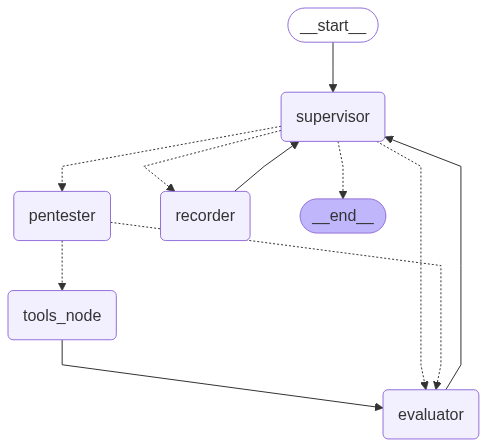

In [63]:
print("\n--- Langgraph Graph Visualization ---")
try:
    from IPython.display import display, Image
    display(Image(pentest_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error during graph visualization: {e}")

# --- 7. Execution ---

In [64]:
# Test queries
# query = "Ping to 8.8.8.8 4 times, and check if the host is up."
# query = "Visit https://dreamhack.io and tell me what this site is about."
query = "Perform a fast port scan on scanme.nmap.org to identify open TCP ports. If any ports are open, proceed with a vulnerability analysis on those ports."

initial_state = {
    "messages": [HumanMessage(content=query)],
    "current_step": 'supervisor', # Start from the supervisor
    "pentest_tasks": [], # Initial tasks will be generated by the supervisor
    "findings": {},
    "recorder_options": {'generate_final_report': False, 'file_names': []}, # Initialize recorder options
    "retry_count": 0 # Initialize retry count for loop prevention
}

print(f"\n--- Starting Pentest: {query} ---")
print("\n--- Pay close attention to 'AI Thought' and 'AI Action' messages from each agent. ---")

# Run Langgraph stream
for chunk in pentest_graph.stream(initial_state, stream_mode='values'):
    # Filter and print messages from each chunk
    messages_in_chunk = chunk.get('messages', [])
    
    # Only process the latest messages to avoid redundant prints for state updates
    # Check if the chunk contains new messages that haven't been printed yet
    if messages_in_chunk:
        # Get only the messages added in this specific chunk
        # This is a heuristic: check if the chunk's messages are an extension of the previous state's messages
        # For `operator.add` or `add_messages`, the new messages are appended.
        # So, we compare the length to identify newly added messages.
        
        # This is a bit tricky with `operator.add` as it concatenates lists.
        # A simpler way for stream_mode='values' is to just process the last few messages in the chunk.
        # Let's assume the last few messages are the most relevant ones added by the current node.
        
        # For demonstration, let's print ALL messages in the chunk that are not the initial query
        # and are not internal AI messages (thought/action).
        
        # However, the goal is to show agent flow. The "[Node Name] - [AI Thought/Action]" handles this.
        # So, we specifically look for those, and ToolMessages.

        for msg in messages_in_chunk:
            if isinstance(msg, HumanMessage) and msg.content == query and len(messages_in_chunk) == 1:
                # This is likely the very first message
                print(f"\n[User Input]: {msg.content}")
            elif isinstance(msg, AIMessage):
                # Check for our custom thought/action prefix
                if msg.content.startswith("Supervisor - [AI Thought]:") or \
                    msg.content.startswith("Pentester - [AI Thought]:") or \
                    msg.content.startswith("Evaluator - [AI Thought]:") or \
                    msg.content.startswith("Recorder - [AI Thought]:"):
                    print(f"\n{msg.content}")
                elif msg.content.startswith("Supervisor - [AI Action]:") or \
                        msg.content.startswith("Pentester - [AI Action]:") or \
                        msg.content.startswith("Evaluator - [AI Action]:") or \
                        msg.content.startswith("Recorder - [AI Action]:"):
                    print(f"{msg.content}")
                else:
                    # Other AI messages (e.g., from tool_node's internal AI invocation or summaries)
                    # Only print if it's not a tool_input_message that was already handled
                    if not (chunk.get('tool_input_message') and msg is chunk['tool_input_message']):
                        print(f"[AI Response]: {msg.content}")
            elif isinstance(msg, ToolMessage):
                print(f"[Tool Result]:\n{msg.content}")
            
    # Optional: Uncomment for detailed debugging to see all state changes
    # pprint(chunk)


--- Starting Pentest: Perform a fast port scan on scanme.nmap.org to identify open TCP ports. If any ports are open, proceed with a vulnerability analysis on those ports. ---

--- Pay close attention to 'AI Thought' and 'AI Action' messages from each agent. ---

[User Input]: Perform a fast port scan on scanme.nmap.org to identify open TCP ports. If any ports are open, proceed with a vulnerability analysis on those ports.
--- Entering Supervisor Node ---
Supervisor - [AI Thought]: Received a new penetration test request. Assigning a fast port scan task on scanme.nmap.org to identify open TCP ports. If any ports are found open, we will proceed with a vulnerability analysis on those ports.

Supervisor - [AI Thought]: Received a new penetration test request. Assigning a fast port scan task on scanme.nmap.org to identify open TCP ports. If any ports are found open, we will proceed with a vulnerability analysis on those ports.
Supervisor - [AI Action]: The next step is 'pentester'.
--- Ent